In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import ray
from prophet import Prophet

Preliminary data changes

In [45]:
df = pd.read_csv("product_sales.csv")
# Drop random columns
df = df.drop(columns=["Unnamed: 107", "94"])
# Melt data and remove strings for week names
df = df.melt(id_vars=["Scode", "Pcode", "Price"], var_name="Week", value_name="Quantity Sold")
df["Week"] = df["Week"].str.extract('(\d+)').astype(int)

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/var/folders/hh/rn_fsj015zz6cmlmssx4w0y00000gn/T/ipykernel_35371/2419203732.py:6: SyntaxWarning: invalid escape sequence '\d'
  df["Week"] = df["Week"].str.extract('(\d+)').astype(int)


Interpolate data: for each date present in the dataset, we create a data point for each SKU when it doesn’t exist– it will use the same quantity and unit price as the most recent date where that SKU has a data point. 
Use time series (ARIMA model) to forecast future dates. Use these as validation data for the hyperparameter search. This way we are making optimal policies for the most recent data, and calculating our loss based on forecasted data.


# Use Prophet for short term interpolation

In [47]:
df

,Scode,Pcode,Price,Week,Quantity Sold
0,Store1,SKU1,$24.00,0,23
1,Store1,SKU2,$63.00,0,23
2,Store1,SKU3,$93.00,0,7
3,Store1,SKU4,$48.00,0,50
4,Store1,SKU5,$62.00,0,8
...,...,...,...,...,...
623995,Store5,SKU1809,$71.00,103,39
623996,Store5,SKU1563,$64.00,103,24
623997,Store5,SKU897,$77.00,103,28
623998,Store5,SKU1142,$81.00,103,31


In [48]:
# Prepare data for Sarima

# Will contain (store, sku) pair
all_unique_combos = []
for store in df["Scode"].unique():
    holder = df[df["Scode"] == store]
    skus = holder["Pcode"].unique()
    for sku in skus:
        all_unique_combos.append((store, sku))


In [49]:
df[(df["Pcode"] == "SKU1") & (df["Scode"] == "Store1")].reset_index(drop=True)

,Scode,Pcode,Price,Week,Quantity Sold
0,Store1,SKU1,$24.00,0,23
1,Store1,SKU1,$24.00,1,48
2,Store1,SKU1,$24.00,2,47
3,Store1,SKU1,$24.00,3,42
4,Store1,SKU1,$24.00,4,22
...,...,...,...,...,...
99,Store1,SKU1,$24.00,99,133
100,Store1,SKU1,$24.00,100,229
101,Store1,SKU1,$24.00,101,381
102,Store1,SKU1,$24.00,102,21


In [70]:
# Parellelize this forecasting for speed
# @ray.remote
def forecast_dates(df, pair):
    value_column = df[(df["Pcode"] == pair[1]) & (df["Scode"] == pair[0])].reset_index(drop=True)
    value_column = value_column["Quantity Sold"]
    start_date = "2023-01-01"  # Choose an arbitrary start date
    date_range = pd.date_range(start=start_date, periods=len(value_column), freq='W') 
    data = pd.DataFrame({'ds': date_range, 'y': value_column})
    model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
    model.fit(data)
    future = model.make_future_dataframe(periods=50, freq='W')
    forecast = model.predict(future)
    return data, forecast

In [71]:
forecast = forecast_dates(df, ("Store1", "SKU1"))

12:36:55 - cmdstanpy - INFO - Chain [1] start processing
12:36:55 - cmdstanpy - INFO - Chain [1] done processing


In [72]:
forecast["yhat"]

0       12.922440
1       15.195659
2       38.186877
3       46.976357
4       35.584879
          ...    
149     36.252976
150     54.842632
151    116.522555
152    193.940501
153    232.368751
Name: yhat, Length: 154, dtype: float64

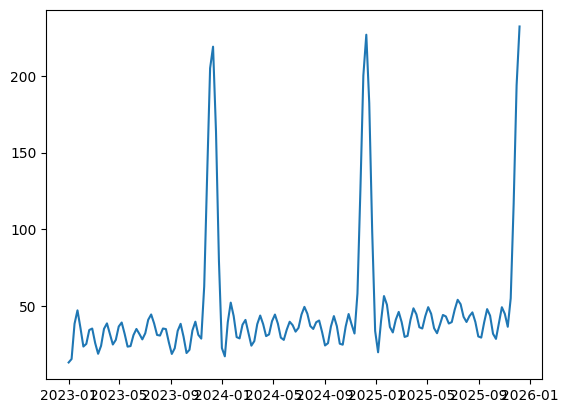

In [73]:
plt.plot(forecast["ds"], forecast["yhat"])
plt.show()